In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import os
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS


In [3]:
fitness_df = utils.load_fitness_data()
print(fitness_df.columns)
fitness_df.head()

Index(['Index', 'src_file', 'game_name', 'domain_name',
       'all_variables_defined', 'all_variables_used', 'all_preferences_used',
       'setup_objects_used', 'no_adjacent_once', 'starts_and_ends_once',
       'variable_not_repeated', 'no_nested_logicals', 'pref_forall_correct',
       'correct_predicate_arity', 'real', 'original_game_name'],
      dtype='object')


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,correct_predicate_arity,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,1.0,1.0,1.0,1.0,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,1.0,1.0,1.0,1.0,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,1.0,1.0,1.0,1.0,True,614dec67f6eb129c3a77defd-6


In [4]:
def base_syntethic_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('ast-mle-samples.pddl', 'ast-mle-regrowth-samples.pddl')) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    if 'ast-mle-samples.pddl' in synthetic_data_src_files:
        syntethic_df.loc[syntethic_df.src_file == 'ast-mle-samples.pddl', 'original_game_name'] = syntethic_df.loc[syntethic_df.src_file == 'ast-mle-samples.pddl', 'game_name']

    return syntethic_df

syntethic_fitness_df = base_syntethic_df(fitness_df)

In [5]:
syntethic_fitness_df.head()

,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,correct_predicate_arity,real,original_game_name
0,98,ast-mle-samples.pddl,game-id-0,medium-objects-room-v1,1.0,0.750000,1.000000,0.0,0.5,0.0,0.818182,0.821429,0.666667,0.409091,False,game-id-0
1,99,ast-mle-samples.pddl,game-id-1,medium-objects-room-v1,1.0,0.600000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.400000,False,game-id-1
2,100,ast-mle-samples.pddl,game-id-2,many-objects-room-v1,1.0,0.750000,1.000000,0.0,1.0,0.0,0.500000,0.846154,0.000000,0.333333,False,game-id-2
3,101,ast-mle-samples.pddl,game-id-3,many-objects-room-v1,1.0,0.375000,0.333333,1.0,1.0,0.0,0.666667,0.750000,0.000000,0.500000,False,game-id-3
4,102,ast-mle-samples.pddl,game-id-4,few-objects-room-v1,1.0,0.666667,1.000000,0.0,1.0,0.0,1.000000,1.000000,1.000000,1.000000,False,game-id-4


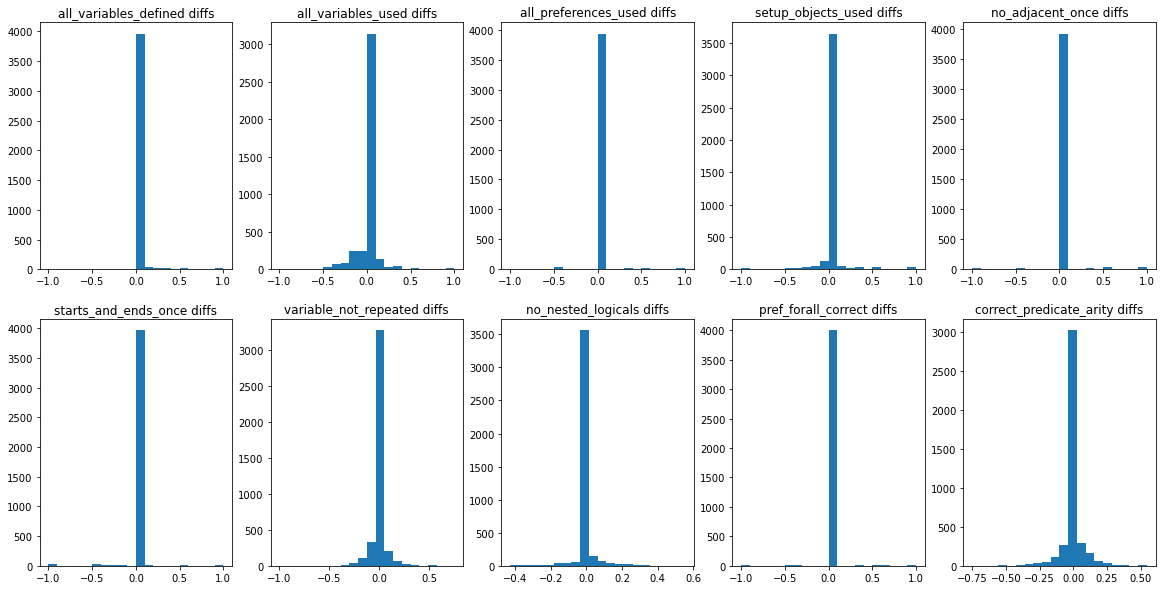

In 41.63% of the games, the regrown game was identical to the original game.


In [6]:
fake_games = syntethic_fitness_df[syntethic_fitness_df.src_file == 'ast-mle-regrowth-samples.pddl'].reset_index()
broadcasted_original = syntethic_fitness_df.loc[[syntethic_fitness_df.index[(syntethic_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0
for column in original_regrown_diffs.columns:
    if column in ('index', 'Index', 'real'):
        continue

    ax = axes[index // 5][index % 5]
    ax.hist(original_regrown_diffs[column], bins=20)
    ax.set_title(f'{column} diffs')
    index += 1

plt.show()
unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

Trying a similar process, but taking the max feature value for each original game

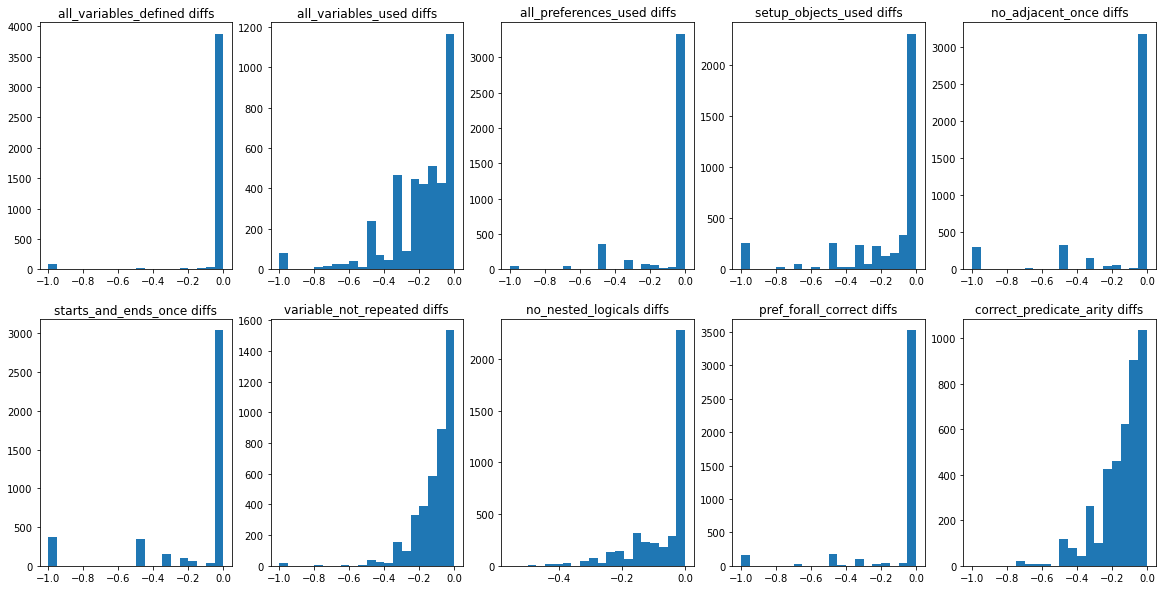

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

original_games = syntethic_fitness_df.original_game_name.unique()

for column in syntethic_fitness_df.columns:
    if column in utils.NON_FEATURE_COLUMNS:
        continue

    diffs = []
    for original_game in original_games:
        game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][column]
        argmax = game_col.argmax()
        diffs.append((game_col - game_col.iloc[argmax])[game_col.index != game_col.index[argmax]].values)
        
    diffs = np.concatenate(diffs)

    ax = axes[index // 5][index % 5]
    ax.hist(diffs, bins=20)
    ax.set_title(f'{column} diffs')
    index += 1

plt.show()

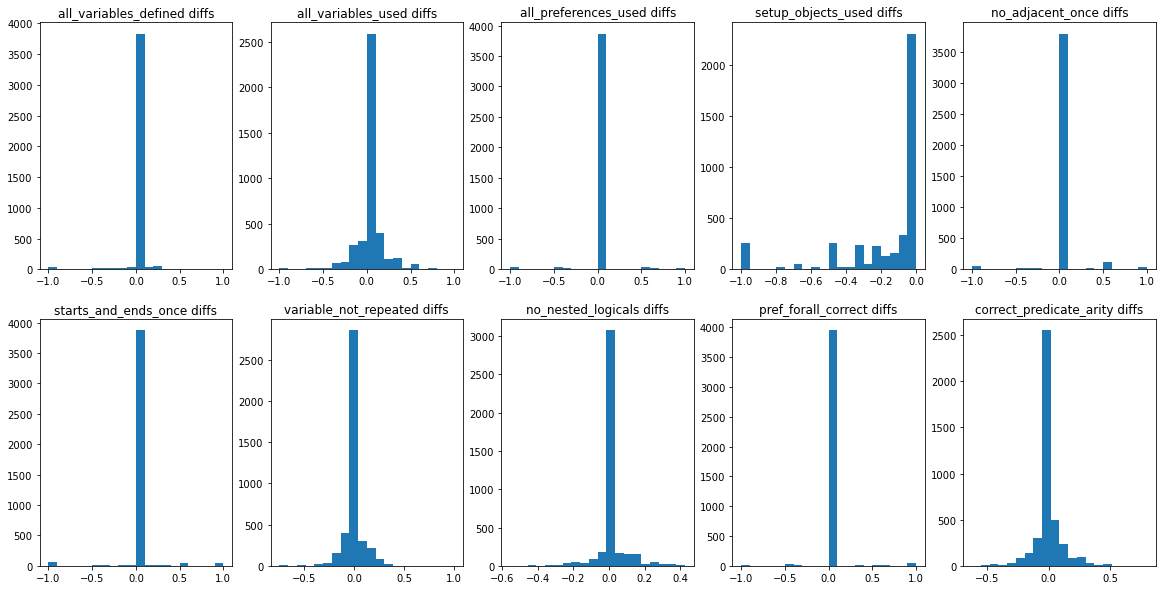

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

original_games = syntethic_fitness_df.original_game_name.unique()
key_column = 'setup_objects_used'

game_idxmaxes = syntethic_fitness_df.groupby('original_game_name')[key_column].idxmax()


for column in syntethic_fitness_df.columns:
    if column in utils.NON_FEATURE_COLUMNS:
        continue

    diffs = []
    for original_game in original_games:
        game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][column]
        game_idxmax = game_idxmaxes[original_game]
        diffs.append((game_col - game_col.loc[game_idxmax])[game_col.index != game_idxmax].values)
        
    diffs = np.concatenate(diffs)

    ax = axes[index // 5][index % 5]
    ax.hist(diffs, bins=20)
    ax.set_title(f'{column} diffs')
    index += 1

plt.show()

# Synthetic experiment approach
* Pick one feature value that is the 'target' feature for this experiment
* For each set of games generated from the same 'source' synthetic game:
    * Find the game in that set that has the highest value on that feature
    * Define that game to the be positive game for the recovery experiment with this feature; treat the remaining games as the negatives. 
* At this point, we have a single designated positive game from each set. 
* Fit the fitness model with these labels.
* Check whether or not the highest coefficient belongs to the feature picked initially.
* Repeat for other features, and potentially for feature combinations


In [9]:
def cross_validate(train: pd.DataFrame, feature_columns: typing.List[str], param_grid: typing.Dict[str, typing.Any],
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    train_tensor = utils.df_to_tensor(train, feature_columns)
    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(train_kwargs=train_kwargs))])

    param_grid['fitness__n_features'] = [len(feature_columns)]

    cv = GridSearchCV(pipeline, param_grid, scoring=utils.evaluate_fitness, cv=5, n_jobs=-1, verbose=0)
    cv.fit(train_tensor, None)
    return cv


def single_feature_parameter_recovery_experiment(df: pd.DataFrame, target_feature: str, 
    param_grid: typing.Dict[str, typing.Any], target_feature_epsilon: float = 0,
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED):
    syntethic_fitness_df = base_syntethic_df(df)

    if feature_columns is None:
        feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
    elif target_feature not in feature_columns:
        raise ValueError(f'Target feature {target_feature} not in feature_columns')

    rng = np.random.default_rng(random_seed)

    game_idxmaxes = []
    for original_game in syntethic_fitness_df.original_game_name.unique():
        game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][target_feature]
        idx = rng.choice(np.argwhere(game_col.values == game_col.values.max()).reshape(-1))
        game_idxmaxes.append(game_col.index[idx])

    syntethic_fitness_df.real = 0
    syntethic_fitness_df.loc[game_idxmaxes, 'real'] = 1
    syntethic_fitness_df.loc[game_idxmaxes, target_feature] += target_feature_epsilon

    feature_group_by = syntethic_fitness_df.groupby('original_game_name')[target_feature].max()

    for i, original_game in enumerate(syntethic_fitness_df.original_game_name.unique()):
        assert(feature_group_by[original_game] == syntethic_fitness_df.loc[game_idxmaxes[i], target_feature])

    train_df, test_df = utils.train_test_split_by_game_name(syntethic_fitness_df, random_seed=random_seed)
    cv = cross_validate(train_df, feature_columns, param_grid, train_kwargs={'random_seed': random_seed})
    best_model = cv.best_estimator_.named_steps['fitness'].model
    weights = best_model.fc1.weight.detach().numpy().reshape(-1)

    target_feature_index = feature_columns.index(target_feature)
    target_feature_is_max_weight = weights.argmax() == target_feature_index
    target_feature_weight_diff = weights[target_feature_index] - weights[np.arange(len(weights)) != target_feature_index].max()
    return {
        'target_feature': target_feature,
        'random_seed': random_seed,
        'is_max_weight': target_feature_is_max_weight,
        'weight_diff': target_feature_weight_diff,
        'best_params': cv.best_params_,
        'best_score': cv.best_score_,
        'target_feature_epsilon': target_feature_epsilon,
    }
    
    


In [11]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,]   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

results_by_feature = defaultdict(list)

for target_feature in [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]:
    print(f'Running {target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        results_by_feature[target_feature].append(single_feature_parameter_recovery_experiment(syntethic_fitness_df, target_feature, test_param_grid, random_seed=seed))


Running all_variables_defined
Running all_variables_used
Running all_preferences_used
Running setup_objects_used
Running no_adjacent_once
Running starts_and_ends_once
Running variable_not_repeated
Running no_nested_logicals
Running pref_forall_correct
Running correct_predicate_arity


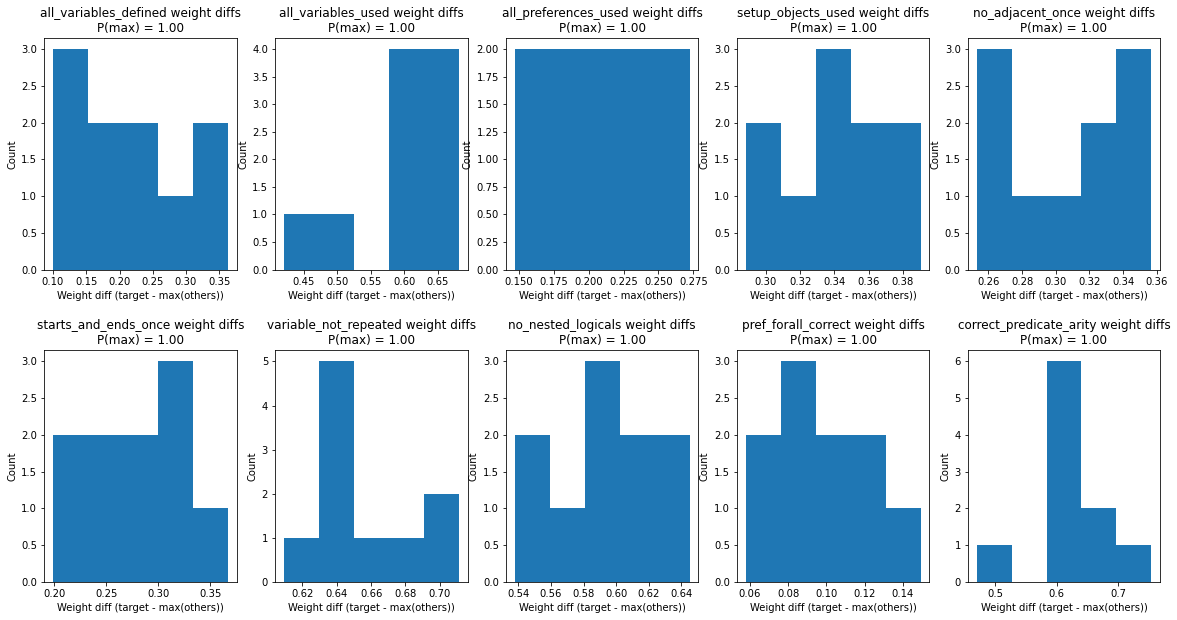

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

for target_feature in results_by_feature:
    results = results_by_feature[target_feature]
    weight_diffs = [r['weight_diff'] for r in results]
    ax = axes[index // 5][index % 5]
    ax.hist(weight_diffs, bins=5)
    ax.set_title(f'{target_feature} weight diffs\nP(max) = {np.mean([r["is_max_weight"] for r in results]):.2f}')
    ax.set_xlabel(f'Weight diff (target - max(others))')
    ax.set_ylabel('Count')
    index += 1

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

for target_feature in results_by_feature_epsilon_01:
    results = results_by_feature_epsilon_01[target_feature]
    weight_diffs = [r['weight_diff'] for r in results]
    ax = axes[index // 5][index % 5]
    ax.hist(weight_diffs, bins=5)
    ax.set_title(f'{target_feature} weight diffs')
    index += 1

plt.show()